# Applying Causal Modelling to synthetic data
 > Trying to make sense of the methods on synthetic and real world data.

**Types of relevant random variables:**

- outcome: variable whose response we are interested in
- treatment: variable which we guess controls the outcome
- common cause: variable that influences both treatment and outcome
- instrumental: variable that only influences treatment
- effect modifier: variable that only influences outcome

**Treatment variable cases:**

- continuous
- discrete

**Causal identification method:**

- backdoor: tries explanations via common causes
- instrumental variable (iv): tries explanations via instrumental variables

**Causal estimation method:**

- *regression based*:
    - *linear regression*
    - *regression discontinuity*: 2 regressions to estimate around a discontinuity in outcome vs some other variable, splitting on the treatment (see [wiki](https://en.wikipedia.org/wiki/Regression_discontinuity_design), how to select the other variable?)
    
- *propensity score based*: 
> The propensity score is the (estimated) probability of treatment given some other data. It can be used as an indirect way to compare observations and group them to compute the treatment effect, see [Austin et al. 2011](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/)

    - types: 
        - *matching*: pairing of samples with and without treatment
        - *stratification*: ranks and groups samples into n groups balancing samples with and without treatment
        - *inverse probability weighting*: uses the inverse of the propensity score to weight the outcome when estimating the effect 
        - *covariate adjustment*: fitting of the outcome depending on the propensity score and treatment values and inspecting the weights of the (linear, omg!) model
        
- *instrumental variable*: ???

In [ ]:
%matplotlib inline

In [ ]:
import dowhy as dw
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns

In [ ]:
plt.style.use('bmh')

## Synthetic data

In [ ]:
n = 1000

In [ ]:
columns = ['y', 'x', 'cc', 'iv', 'em']
outcome, treatment, common_cause, instrumental, effect_modifier = columns
obs = pd.DataFrame(np.empty((n, len(columns))), columns=columns)
obs.head()

,y,x,cc,iv,em
0,6.918073e-310,6.953347e-310,6.953347e-310,6.953347e-310,9.050508e-56
1,0.000000e+00,1.577139e+54,9.303825e+68,2.281131e+06,7.409439e-57
2,2.781882e+266,2.261634e+06,1.546531e+45,2.491935e+209,1.822133e+267
3,2.166216e+59,2.187837e+11,2.261598e+06,1.681441e-75,7.403119e+194
4,3.858872e-76,6.030943e+233,1.195546e+281,7.088516e+275,1.677383e-75


### Discrete treatment variable

**Generating**

In [ ]:
obs[instrumental] = stats.norm.rvs(size=n)
obs[common_cause] = stats.norm.rvs(size=n)

Treatment

In [ ]:
# treatment is independent of the common cause
# obs[treatment] = np.random.choice([False,True], p=[.7, .3], size=n)

# treatment is dependent on the common cause
obs[treatment] = obs[common_cause] > 0

Outcome

In [ ]:
obs[effect_modifier] = stats.norm.rvs(size=n)

In [ ]:
# outcome depends only on the treatment
# obs[outcome] = 1.5 * obs[treatment] ** 1.

# outcome depends on the treatment and a common cause
obs[outcome] = 1.5 * obs[treatment] ** 1. + obs[common_cause]

# outcome depends on the treatment and the effect modifier
# obs[outcome] = 1.5 * obs[treatment] ** 1. * obs[effect_modifier]

# outcome depends on the treatment, a common cause and an effect modifier
# obs[outcome] = 1.5 * obs[treatment] ** 1. * obs[effect_modifier] + obs[common_cause]


Visualizing

In [ ]:
display(obs.head(), obs[treatment].value_counts(normalize=True).to_frame(),
        obs.describe().T)

,y,x,cc,iv,em
0,-0.251278,False,-0.251278,0.917056,1.494383
1,1.563431,True,0.063431,-1.107328,1.438409
2,1.961911,True,0.461911,0.794080,-1.079251
3,-0.321904,False,-0.321904,-1.009816,0.163311
4,-0.932520,False,-0.932520,0.382850,1.534593


,x
False,0.529
True,0.471


,count,mean,std,min,25%,50%,75%,max
y,1000.0,0.687885,1.644531,-2.732508,-0.684833,-0.071427,2.145793,4.831130
cc,1000.0,-0.018615,0.981040,-2.732508,-0.684833,-0.071427,0.645793,3.331130
iv,1000.0,0.018760,1.008698,-2.980136,-0.652960,-0.019279,0.705540,3.395516
em,1000.0,0.001939,1.027286,-3.176388,-0.698916,-0.005624,0.743084,4.220347


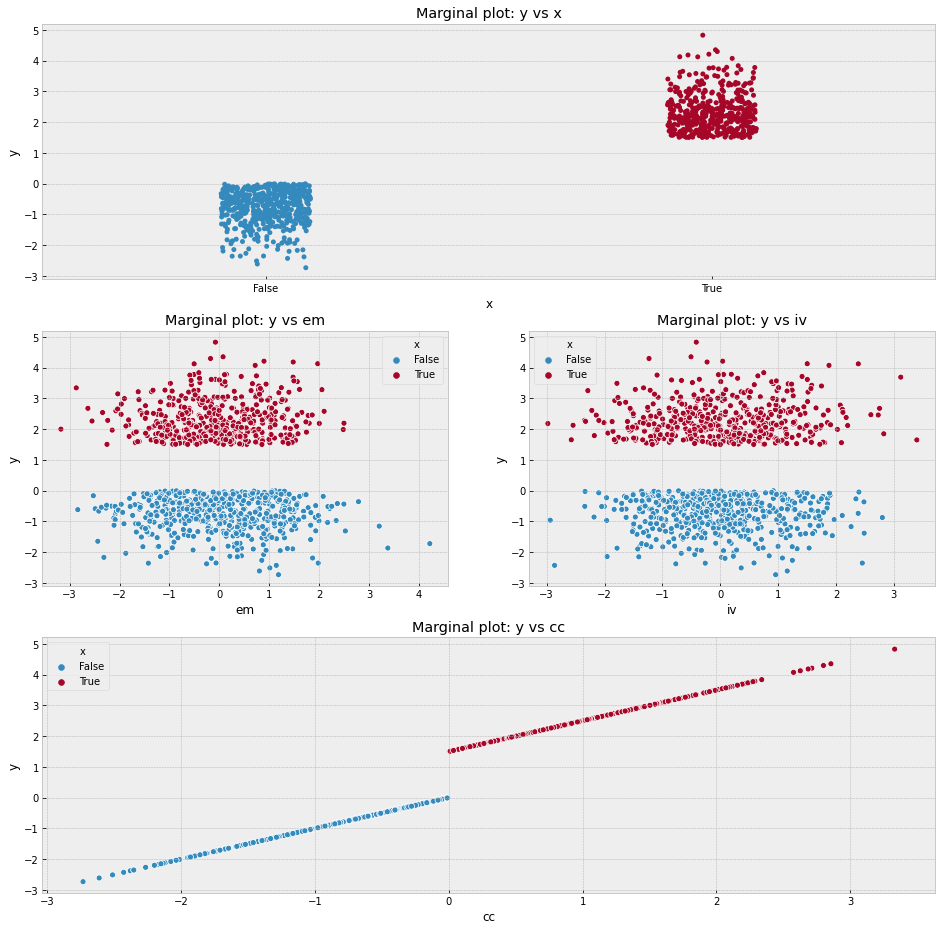

In [ ]:
fig, axs = plt.subplots(figsize=(16,16), nrows=3, ncols=2)

gs = axs[0,0].get_gridspec()
axs[0,0].remove()
axs[0,1].remove()
ax = fig.add_subplot(gs[0,:])
sns.stripplot(data=obs, x=treatment, y=outcome, ax=ax)
ax.set(title=f'Marginal plot: {outcome} vs {treatment}')

ax = axs[1,0]
sns.scatterplot(data=obs, x=effect_modifier, y=outcome, hue=treatment, 
                ax=ax)
ax.set(title=f'Marginal plot: {outcome} vs {effect_modifier}')

ax = axs[1,1]
sns.scatterplot(data=obs, x=instrumental, y=outcome, hue=treatment, 
                ax=ax)
ax.set(title=f'Marginal plot: {outcome} vs {instrumental}')

gs = axs[2,0].get_gridspec()
axs[2,0].remove()
axs[2,1].remove()
ax = fig.add_subplot(gs[2,:])
sns.scatterplot(data=obs, x=common_cause, y=outcome, hue=treatment, 
                ax=ax)
ax.set(title=f'Marginal plot: {outcome} vs {common_cause}')

plt.show()

**Modelling**

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['x'] on outcome ['y']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


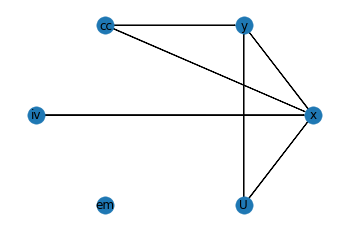

In [ ]:
model = dw.CausalModel(obs.copy(), treatment, outcome, 
                       common_causes=[common_cause],
                       instruments=[instrumental],
                       effect_modifiers=[effect_modifier],
                       )
model.view_model()

In [ ]:
identified_effect = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_effect)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['cc', 'U']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['iv']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                     
────(Expectation(y|cc))
d[x]                   
Estimand assumption 1, Unconfoundedness: If U→{x} and U→y then P(y|x,cc,U) = P(y|x,cc)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [iv])*Derivative([x], [iv])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{iv})
Estimand assumption 2, Exclusion: If we remove {iv}→{x}, then ¬({iv}→y)



**Estimating**

`regression_discontinuity` throws 
> AttributeError: 'RegressionDiscontinuityEstimator' object has no attribute 'rd_variable_name'

Odd: using `estimand_name` 'iv' or 'backdoor' does not really seems to make a difference

In [ ]:
# estimand_name = 'iv'
estimand_name = 'backdoor'

# approach_name = 'propensity_score_stratification'
# approach_name = 'propensity_score_weighting'
# approach_name = 'propensity_score_matching'
# approach_name = 'linear_regression'
approach_name = 'regression_discontinuity'
# approach_name = 'instrumental_variable'

props = dict(
    method_name = f'{estimand_name}.{approach_name}',   
    target_units = 'atc',
    control_value = False,
    treatment_value = True,
    # for regression discontinuity
    method_params = dict(rd_variable_name = common_cause,
                         rd_threshold_value = 0,
                         rd_bandwidth = .05)
)

print('method_name', props['method_name'])

estimated_effect = model.estimate_effect(identified_effect,
                                         **props)
print(estimated_effect)

INFO:dowhy.causal_estimator:Using Regression Discontinuity Estimator
INFO:dowhy.causal_estimator:
INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                                              
Expectation(Derivative(y, local_rd_variable))⋅Expectation(Derivative(x, local_

             -1
rd_variable))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{iv})
Estimand assumption 2, Exclusion: If we remove {iv}→{x}, then ¬({iv}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['local_treatment'] is affected in the same way by common causes of ['local_treatment'] and local_outcome
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome local_outcome is affected in the same way by common causes of ['local_treatment'] and local_outcome



method_name backdoor.regression_discontinuity
     local_rd_variable  local_treatment  local_outcome
20            0.006556             True       1.506556
45           -0.042975            False      -0.042975
83           -0.043923            False      -0.043923
84           -0.001724            False      -0.001724
86            0.016218             True       1.516218
87           -0.018013            False      -0.018013
99           -0.037584            False      -0.037584
114          -0.011067            False      -0.011067
156          -0.038451            False      -0.038451
218          -0.012932            False      -0.012932
292          -0.043444            False      -0.043444
293          -0.039124            False      -0.039124
415          -0.030913            False      -0.030913
425          -0.025004            False      -0.025004
429          -0.019277            False      -0.019277
452          -0.045595            False      -0.045595
509           0.007

Testing the effect

In [ ]:
%%time
n_reps = 10
method_names = ['random_common_cause', 'placebo_treatment_refuter',
                'data_subset_refuter', 'add_unobserved_common_cause']

props = dict(
    # data_subset_refuter
    subset_fraction = .9,
    # placebo_treatment_refuter
    placebo_type = 'permute',
    # add_unobserved_common_cause
    effect_strength_on_treatment = 1.,
    effect_strength_on_outcome = 1.,
    confounders_effect_on_treatment = 'binary_flip',  # 'linear', 'binary_flip'
    confounders_effect_on_outcome = 'linear',  # 'linear', 'binary_flip'
    
)

tests = []

for rep in range(n_reps):
    for method_name in method_names:
        tested_effect = model.refute_estimate(identified_effect, estimated_effect,
                                              method_name=method_name, **props)
        tests.append({'method_name': method_name, 'new_effect': tested_effect.new_effect[0]})

tests = pd.DataFrame(tests, columns=['method_name', 'new_effect'])

In [ ]:
tests.head()

,method_name,new_effect
0,random_common_cause,1.567824
1,placebo_treatment_refuter,23.570390
2,data_subset_refuter,1.568074
3,add_unobserved_common_cause,-1.179830
4,random_common_cause,1.567824


*Random common cause*: adds a common cause drawing values from some distribution

*Placebo treatment refuter*: Shuffles the treatment values across samples

*Data subset refuter*: recomputing the estimate using a subset of the original data

*Add unobserved common cause*: how is this different to the random common cause?

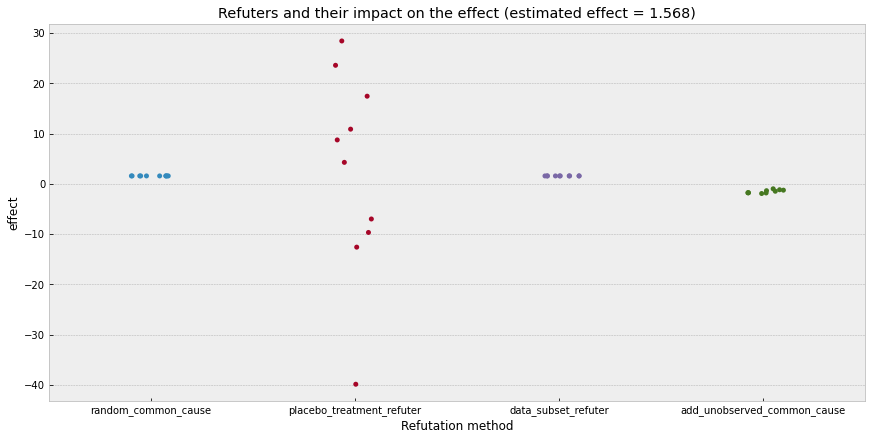

In [ ]:
fig, ax = plt.subplots(figsize=(12,6), constrained_layout=True)
sns.stripplot(x='method_name', y='new_effect', data=tests, ax=ax)
ax.set(title=f'Refuters and their impact on the effect (estimated effect = {estimated_effect.value:.3f})',
       xlabel='Refutation method', ylabel='effect')
plt.show()

### Continuous treatment variable

**Generating**

In [ ]:
obs[instrumental] = stats.norm.rvs(size=n)
obs[common_cause] = stats.norm.rvs(size=n)

Treatment

In [ ]:
# treatment is independent of the common cause
obs[treatment] = stats.uniform.rvs(size=n)

# treatment is dependent on the common cause
# obs[treatment] = obs[common_cause] > 0

Outcome

In [ ]:
obs[effect_modifier] = stats.norm.rvs(size=n)

In [ ]:
# outcome depends only on the treatment
obs[outcome] = 1.5 * obs[treatment] ** 1.

# outcome depends on the treatment and a common cause
# obs[outcome] = 1.5 * obs[treatment] ** 1. + obs[common_cause]

# outcome depends on the treatment and the effect modifier
# obs[outcome] = 1.5 * obs[treatment] ** 1. * obs[effect_modifier]

# outcome depends on the treatment, a common cause and an effect modifier
# obs[outcome] = 1.5 * obs[treatment] ** 1. * obs[effect_modifier] + obs[common_cause]


Visualizing

In [ ]:
display(obs.head(), obs[treatment].value_counts(normalize=True).to_frame(),
        obs.describe().T)

,y,x,cc,iv,em
0,0.280577,0.187051,-0.251278,0.917056,-1.505974
1,0.775708,0.517139,0.063431,-1.107328,2.063922
2,0.682341,0.454894,0.461911,0.794080,-1.435042
3,0.153469,0.102313,-0.321904,-1.009816,0.105005
4,0.936802,0.624535,-0.932520,0.382850,0.675198


,x
0.207688,0.001
0.935084,0.001
0.491385,0.001
0.478399,0.001
0.745619,0.001
...,...
0.308283,0.001
0.413835,0.001
0.833249,0.001
0.891169,0.001


,count,mean,std,min,25%,50%,75%,max
y,1000.0,0.764957,0.423432,0.004876,0.408544,0.749393,1.141149,1.499710
x,1000.0,0.509972,0.282288,0.003250,0.272363,0.499596,0.760766,0.999807
cc,1000.0,-0.018615,0.981040,-2.732508,-0.684833,-0.071427,0.645793,3.331130
iv,1000.0,0.018760,1.008698,-2.980136,-0.652960,-0.019279,0.705540,3.395516
em,1000.0,-0.014987,1.032581,-3.401947,-0.690381,0.014271,0.686410,3.991419


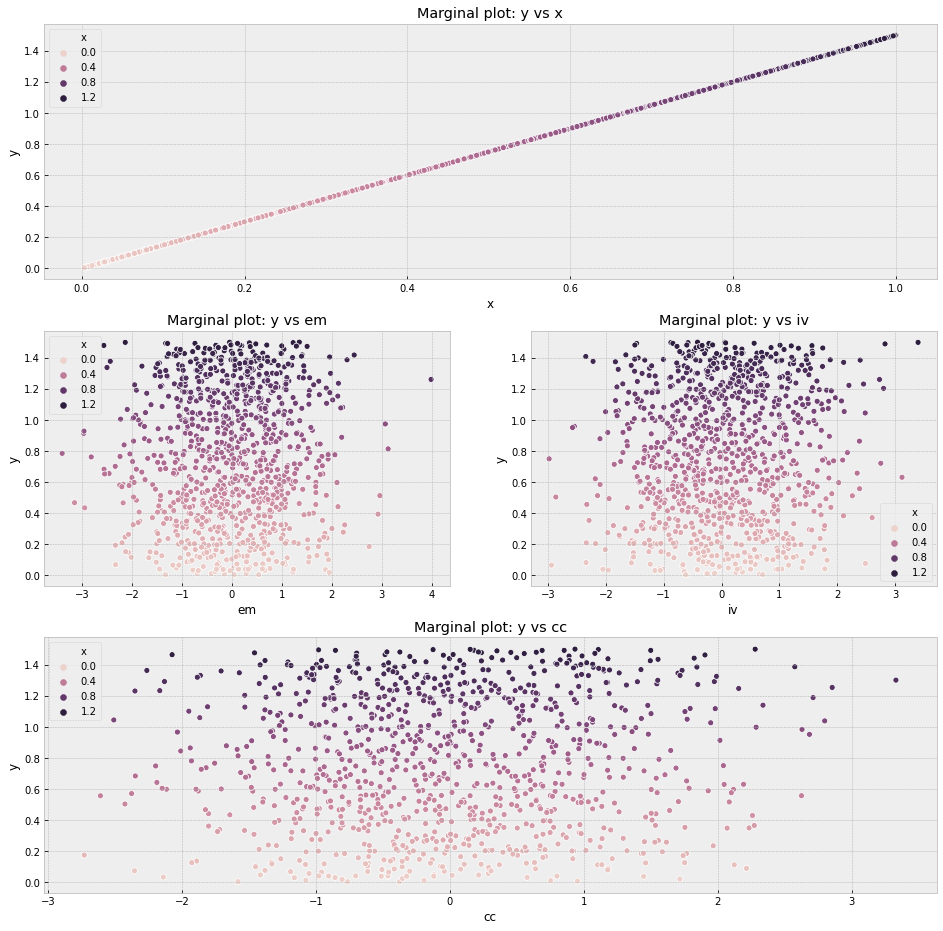

In [ ]:
fig, axs = plt.subplots(figsize=(16,16), nrows=3, ncols=2)

gs = axs[0,0].get_gridspec()
axs[0,0].remove()
axs[0,1].remove()
ax = fig.add_subplot(gs[0,:])
sns.scatterplot(data=obs, x=treatment, y=outcome, hue=treatment, ax=ax)
ax.set(title=f'Marginal plot: {outcome} vs {treatment}')

ax = axs[1,0]
sns.scatterplot(data=obs, x=effect_modifier, y=outcome, hue=treatment, 
                ax=ax)
ax.set(title=f'Marginal plot: {outcome} vs {effect_modifier}')

ax = axs[1,1]
sns.scatterplot(data=obs, x=instrumental, y=outcome, hue=treatment, 
                ax=ax)
ax.set(title=f'Marginal plot: {outcome} vs {instrumental}')

gs = axs[2,0].get_gridspec()
axs[2,0].remove()
axs[2,1].remove()
ax = fig.add_subplot(gs[2,:])
sns.scatterplot(data=obs, x=common_cause, y=outcome, hue=treatment, 
                ax=ax)
ax.set(title=f'Marginal plot: {outcome} vs {common_cause}')

plt.show()

**Modelling**

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['x'] on outcome ['y']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


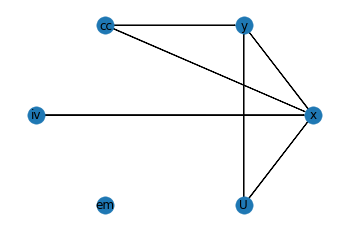

In [ ]:
model = dw.CausalModel(obs.copy(), treatment, outcome, 
                       common_causes=[common_cause],
                       instruments=[instrumental],
                       effect_modifiers=[effect_modifier],
                       )
model.view_model()

In [ ]:
identified_effect = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_effect)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['cc', 'U']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['iv']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                     
────(Expectation(y|cc))
d[x]                   
Estimand assumption 1, Unconfoundedness: If U→{x} and U→y then P(y|x,cc,U) = P(y|x,cc)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [iv])*Derivative([x], [iv])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{iv})
Estimand assumption 2, Exclusion: If we remove {iv}→{x}, then ¬({iv}→y)



**Estimating**

`regression_discontinuity` throws 
> AttributeError: 'RegressionDiscontinuityEstimator' object has no attribute 'rd_variable_name'

Odd: using `estimand_name` 'iv' or 'backdoor' does not really seems to make a difference

In [ ]:
# estimand_name = 'iv'
estimand_name = 'backdoor'

approach_name = 'linear_regression'
# approach_name = 'regression_discontinuity'
# approach_name = 'instrumental_variable'

props = dict(
    method_name = f'{estimand_name}.{approach_name}',   
    target_units = 'atc',
    control_value = False,
    treatment_value = True,
    # for regression discontinuity
    method_params = dict(rd_variable_name = common_cause,
                         rd_threshold_value = 0,
                         rd_bandwidth = .05)
)

print('method_name', props['method_name'])

estimated_effect = model.estimate_effect(identified_effect,
                                         **props)
print(estimated_effect)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~x+cc+x*em


method_name backdoor.linear_regression
*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                     
────(Expectation(y|cc))
d[x]                   
Estimand assumption 1, Unconfoundedness: If U→{x} and U→y then P(y|x,cc,U) = P(y|x,cc)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [iv])*Derivative([x], [iv])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{iv})
Estimand assumption 2, Exclusion: If we remove {iv}→{x}, then ¬({iv}→y)

## Realized estimand
b: y~x+cc+x*em
## Estimate
Value: 1.4999999999999991



Testing the effect

In [ ]:
%%time
n_reps = 10
method_names = ['random_common_cause', 'placebo_treatment_refuter',
                'data_subset_refuter', 'add_unobserved_common_cause']

props = dict(
    # data_subset_refuter
    subset_fraction = .9,
    # placebo_treatment_refuter
    placebo_type = 'permute',
    # add_unobserved_common_cause
    effect_strength_on_treatment = 1.,
    effect_strength_on_outcome = 1.,
    confounders_effect_on_treatment = 'linear',  # 'linear', 'binary_flip'
    confounders_effect_on_outcome = 'linear',  # 'linear', 'binary_flip'
    
)

tests = []

for rep in range(n_reps):
    for method_name in method_names:
        tested_effect = model.refute_estimate(identified_effect, estimated_effect,
                                              method_name=method_name, **props)
        tests.append({'method_name': method_name, 'new_effect': tested_effect.new_effect[0]})

tests = pd.DataFrame(tests, columns=['method_name', 'new_effect'])

In [ ]:
tests.head()

,method_name,new_effect
0,random_common_cause,1.500000
1,placebo_treatment_refuter,0.010423
2,data_subset_refuter,1.500000
3,add_unobserved_common_cause,1.039814
4,random_common_cause,1.500000


*Random common cause*: adds a common cause drawing values from some distribution

*Placebo treatment refuter*: Shuffles the treatment values across samples

*Data subset refuter*: recomputing the estimate using a subset of the original data

*Add unobserved common cause*: how is this different to the random common cause?

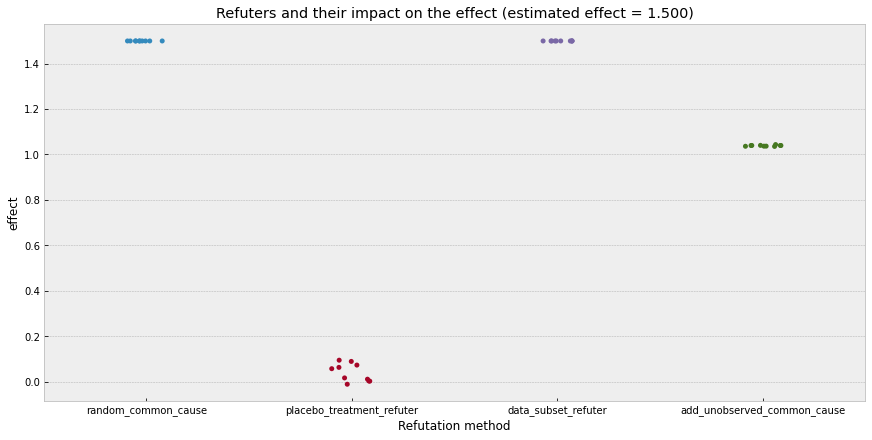

In [ ]:
fig, ax = plt.subplots(figsize=(12,6), constrained_layout=True)
sns.stripplot(x='method_name', y='new_effect', data=tests, ax=ax)
ax.set(title=f'Refuters and their impact on the effect (estimated effect = {estimated_effect.value:.3f})',
       xlabel='Refutation method', ylabel='effect')
plt.show()